# Temperature Forecasting using LSTMs

In [1]:
import os

data_dir = '/Users/brandon/data/jena_climate/'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

# prep
lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(len(lines))
header

420551


['"Date Time"',
 '"p (mbar)"',
 '"T (degC)"',
 '"Tpot (K)"',
 '"Tdew (degC)"',
 '"rh (%)"',
 '"VPmax (mbar)"',
 '"VPact (mbar)"',
 '"VPdef (mbar)"',
 '"sh (g/kg)"',
 '"H2OC (mmol/mol)"',
 '"rho (g/m**3)"',
 '"wv (m/s)"',
 '"max. wv (m/s)"',
 '"wd (deg)"']

In [2]:
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

## Plot Temperature Timeseries

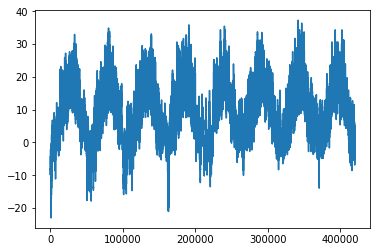

In [3]:
from matplotlib import pyplot as plt
%matplotlib inline

temp = float_data[:, 1] #<1> temperature (in degrees Celsius)
plt.plot(range(len(temp)), temp)

### First 10 days 

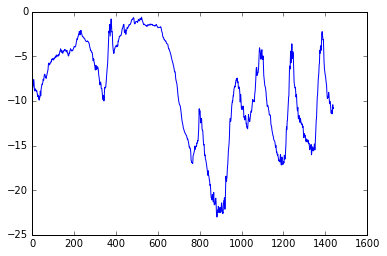

In [6]:
plt.plot(range(1440), temp[:1440])

## Preparing data

lookback = 720  -- observations go back 5 days

steps = 6 -- obs sampled one data pt per hr

delay = 144  -- targets are 24hrs in future

In [4]:
# timeseries is using a different scale -- normalize each values 
# python generator to input current array to give batches of data from recent past

# preprocess by subtracting the mean of each timeseries and divide by std dev
mean = float_data[:2000000].mean(axis=0)
float_data -= mean
std = float_data[:2000000].std(axis=0)
float_data /= std

In [5]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

#### Training, validation and test generators

In [6]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# This is how many steps to draw from `val_gen`
# in order to see the whole validation set:
val_steps = (300000 - 200001 - lookback) // batch_size

# This is how many steps to draw from `test_gen`
# in order to see the whole test set:
test_steps = (len(float_data) - 300001 - lookback) // batch_size

## Non ML Baseline

Data was noramlized to center on 0 and have a std deviation of  1

In [7]:
# MAE 
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds-targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
evaluate_naive_method()

0.304497124411


In [8]:
# convert mae back to celsius error
# Large average absolute error = 2.44
celsius_mae = 0.29 *std[1]
celsius_mae

2.4427730067538058

## ML Approach

Fully connected model by flattening data through 2 dense layers. Last layer without activation function (typical for regression)

In [9]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
import keras

Using TensorFlow backend.


In [12]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')

history = model.fit_generator(train_gen, 
                             steps_per_epoch=500,
          
                              epochs=20,
                             validation_data=val_gen,
                             validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 14s 29ms/step - loss: 1.2674 - val_loss: 0.4586
Epoch 2/20
500/500 [==============================] - 14s 29ms/step - loss: 0.3530 - val_loss: 0.3073
Epoch 3/20
500/500 [==============================] - 17s 34ms/step - loss: 0.2996 - val_loss: 0.3003
Epoch 4/20
500/500 [==============================] - 23s 47ms/step - loss: 0.2848 - val_loss: 0.3146
Epoch 5/20
500/500 [==============================] - 15s 30ms/step - loss: 0.2689 - val_loss: 0.3160
Epoch 6/20
500/500 [==============================] - 14s 29ms/step - loss: 0.2623 - val_loss: 0.3219
Epoch 7/20
500/500 [==============================] - 16s 32ms/step - loss: 0.2569 - val_loss: 0.3795
Epoch 8/20
500/500 [==============================] - 15s 30ms/step - loss: 0.2507 - val_loss: 0.3266
Epoch 9/20
500/500 [==============================] - 17s 34ms/step - loss: 0.2458 - val_loss: 0.3244
Epoch 10/20
500/500 [==============================] - 19s 39ms/step - loss: 0.240

In [15]:
model.save('weather-ml-base.h5')

In [10]:
model = keras.models.load_model('weather-ml-base.h5')

#### Loss curve for validation and training

<IPython.core.display.Javascript object>


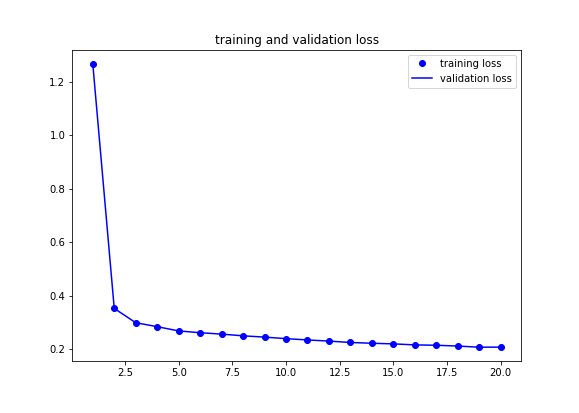

In [13]:
import matplotlib.pyplot as plt
%matplotlib notebook 

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()
plt.show()

# Recurrent-Sequence Processing Model

This doesn't flatten the timeseries where we keep the sequence in mind

In [ ]:
model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                             steps_per_epoch=500,
                             epochs=20,
                             validation_data=val_gen,
                             validation_steps=val_steps)

Epoch 1/20
279/500 [===============>..............] - ETA: 2:12 - loss: 0.3223